Author: John Woolley

Credit for original idea, calibration and discrimination coefficient code: Eric Chiang

# Loading Dataset

This data can be found on Kaggle here: https://www.kaggle.com/mnassrib/telecom-churn-datasets

In [2]:
import pandas as pd
churn80 = pd.read_csv('churn-bigml-80.csv')
churn20 = pd.read_csv('churn-bigml-20.csv')
df = churn80.head().T
df['type'] = churn80.dtypes
df

,0,1,2,3,4,type
State,KS,OH,NJ,OH,OK,object
Account length,128,107,137,84,75,int64
Area code,415,415,415,408,415,int64
International plan,No,No,No,Yes,Yes,object
Voice mail plan,Yes,Yes,No,No,No,object
Number vmail messages,25,26,0,0,0,int64
Total day minutes,265.1,161.6,243.4,299.4,166.7,float64
Total day calls,110,123,114,71,113,int64
Total day charge,45.07,27.47,41.38,50.9,28.34,float64
Total eve minutes,197.4,195.5,121.2,61.9,148.3,float64


# Preprocessing data

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
# Isolate target variable
churn_result = churn80['Churn']
y = np.where(churn_result == True, 1, 0)
# Drop unnecessary columns
to_drop = ['State', 'Area code', 'Churn']
churn_feat_space = churn80.drop(to_drop, axis=1)
# Convert yes/no strings to bools
yes_no_cols = ['International plan', 'Voice mail plan']
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'Yes'
# Convert to numpy array and use sklearn scaler
X = churn_feat_space.values.astype(np.float)
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("Feature space holds {} obs and {} features".format(X.shape[0], X.shape[1]))
print( "Unique target labels: {}".format(np.unique(y)))

Feature space holds 2666 obs and 17 features
Unique target labels: [0 1]


# Define K-fold CV Prediction Function

In [4]:
from sklearn.model_selection import KFold

def run_cv(X, y, clf_class, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    y_pred = y.copy()
    for train_index, cv_index in kf.split(X):
        X_train, X_cv = X[train_index], X[cv_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train, y_train)
        y_pred[cv_index] = clf.predict(X_cv)
    return y_pred

# Measuring Accuracy

In [5]:
np.random.seed(0)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

SVC_pred = run_cv(X,y,SVC)
RF_pred = run_cv(X,y,RF)
KNN_pred = run_cv(X,y,KNN)
print('Support Vector Machine: {}'.format(accuracy(y, SVC_pred)))
print('Random Forest: {}'.format(accuracy(y, RF_pred)))
print('K-nearest Neighbors: {}'.format(accuracy(y, KNN_pred)))

Support Vector Machine: 0.9122280570142536
Random Forest: 0.9508627156789198
K-nearest Neighbors: 0.8897224306076519


# Measuring Precision and Recall

In [6]:
from sklearn.metrics import confusion_matrix
from IPython.display import display

y = np.array(y)
class_names = np.unique(y)

confusion_matrices = {
    'SVM': confusion_matrix(y, SVC_pred),
    'RF': confusion_matrix(y, RF_pred),
    'KNN': confusion_matrix(y, KNN_pred)
}

for k, v in confusion_matrices.items():
    print(k)
    tn, fp, fn, tp = v.ravel()
    print('Precision: {}'.format(tp/(tp+fp)))
    print('Recall: {}\n'.format(tp/(tp+fn)))

SVM
Precision: 0.8811881188118812
Recall: 0.4587628865979381

RF
Precision: 0.9326599326599326
Recall: 0.7139175257731959

KNN
Precision: 0.7732558139534884
Recall: 0.3427835051546392



# Confusion Matrix Visualization

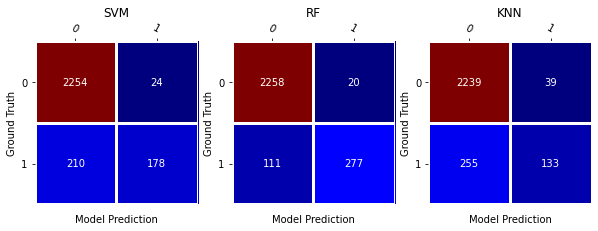

In [7]:
from support.pltsupport import cm_heatmap
cm_heatmap(confusion_matrices)

# Define K-Fold CV Probability Function

In [8]:
np.random.seed(0)
def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    
    for train_index, cv_index in kf.split(X):
        y_prob = np.zeros((len(y),))
        X_train, X_cv = X[train_index], X[cv_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train, y_train)
        try:
            y_prob[cv_index] = clf.predict_proba(X_cv)[:, 1]
        except AttributeError:
            prob_pos = clf.decision_function(X_cv)
            y_prob[cv_index] = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    return y_prob
clfs = {'RF': RF, 'SVM':SVC, 'KNN':KNN}
probs = {k: run_prob_cv(X, y, v) for k, v in clfs.items()}

# Visualization of Calibration

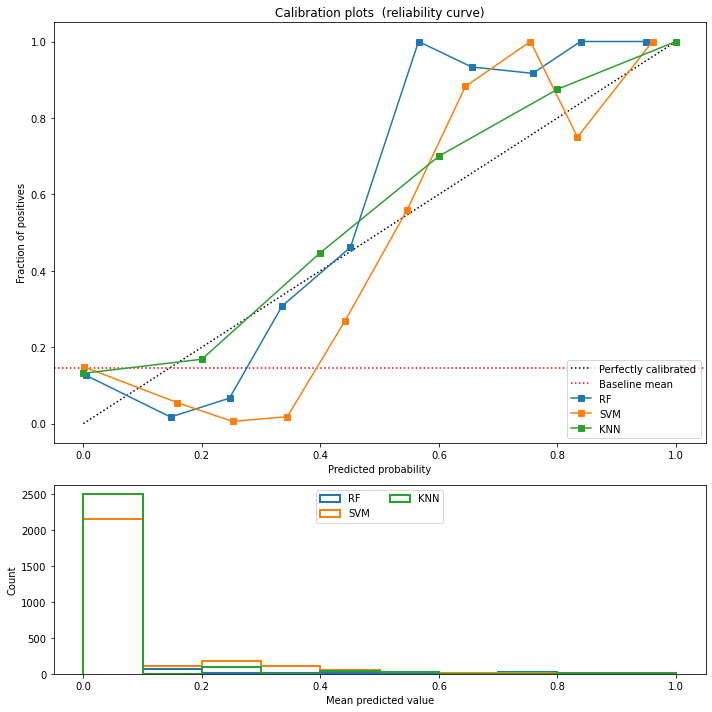

In [9]:
from support.pltsupport import calibration_plot
calibration_plot(y, probs)

# Measuring Calibration and Discrimination Numerically

In [10]:
np.random.seed(0)
from support.churn_measurements import calibration, discrimination
def print_measurements(pred_prob):
    churn_prob, is_churn = pred_prob, y == 1
    print("  %-20s %.4f" % ("Calibration Error", calibration(churn_prob,
    is_churn)))
    print("  %-20s %.4f" % ("Discrimination", discrimination(churn_prob,
    is_churn)))
print("Note -- Lower calibration is better, higher discrimination is better")
print("Support vector machines:")
print_measurements(run_prob_cv(X,y,SVC))
print("Random forests:")
print_measurements(run_prob_cv(X,y,RF))
print("K-nearest-neighbors:")
print_measurements(run_prob_cv(X,y,KNN))

Note -- Lower calibration is better, higher discrimination is better
Support vector machines:
  Calibration Error    0.0227
  Discrimination       0.0137
Random forests:
  Calibration Error    0.0167
  Discrimination       0.0133
K-nearest-neighbors:
  Calibration Error    0.0168
  Discrimination       0.0063
